## 2022_CSE5ML_Lab_9B: Understand CNN model using VGG16
As we learned in Lab 9A, the VGG16 model was pretrained with the ImageNet dataset with the image size of 224*224 for each image. Because of the bigger size of each image, it can be easier to clearly visualize the images to understand the model. The most complex layer in the CNN model is the convolutional layer, so the focus of the lab is to understand the what each covolutional layer does, particularly, how each filter in the convolutional layer functions.

First, let's load the VGG16 model with the function that we leared in 9A.

In [1]:
# load vgg model
from keras.applications.vgg16 import VGG16

# load the model with default setting of using trained imagenet weights 
model = VGG16()
# summarize the model
model.summary()

Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_____________________________________________

### Visualize Filters of Convolutional Layers

#### Method 1: Visualize Filters Directly
The simplest visualization to perform is to plot the learned filters directly.

In neural network, the learned filters are simply weights, but because of the specialized two-dimensional structure of the filters, the weight values have a spatial relationship to each other and plotting each filter as a two-dimensional image can be meaningful.

The first step is to review the filters in the model, to see what we have to work with.

The model summary printed in the previous section summarizes the output shape of each layer, e.g. the shape of the resulting feature maps. It does not give any idea of the shape of the filters (weights) in the network, only the total number of weights per layer.

We can access all of the layers of the model via the model.layers property.

Each layer has a layer.name property, where the convolutional layers have a naming convolution like block#_conv#, where the ‘#‘ is an integer. Therefore, we can check the name of each layer and skip any that don’t contain the string ‘conv‘.

Each convolutional layer has two sets of weights.One is the filters and the other is the bias values. These are accessible via the layer.get_weights() function. We can retrieve these weights and then summarize their shape.

In [2]:
# summarize filter shapes
for layer in model.layers:
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue
    # get filter weights
    filters, biases = layer.get_weights()
    print(layer.name, filters.shape)

block1_conv1 (3, 3, 3, 64)
block1_conv2 (3, 3, 64, 64)
block2_conv1 (3, 3, 64, 128)
block2_conv2 (3, 3, 128, 128)
block3_conv1 (3, 3, 128, 256)
block3_conv2 (3, 3, 256, 256)
block3_conv3 (3, 3, 256, 256)
block4_conv1 (3, 3, 256, 512)
block4_conv2 (3, 3, 512, 512)
block4_conv3 (3, 3, 512, 512)
block5_conv1 (3, 3, 512, 512)
block5_conv2 (3, 3, 512, 512)
block5_conv3 (3, 3, 512, 512)


Filter shape represents (filter_size_row, filter_size_column, num_channel, num_filter). We can see that all convolutional layers use 3×3 filters, which are small and easy to interpret.

An architectural concern with a convolutional neural network is that the depth of a filter must match the depth of the input for the filter (e.g. the number of channels).

We can see that for the input image with 3 channels for red, green and blue, that each filter has a depth of three. We could visualize one filter as a plot with three images, one for each channel, or compress all three down to a single color image, or even just look at the first channel and assume the other channels will look the same. In this example, we visualize the three channels separately to understand it better.

We can retrieve the filters from the first convolutional layer as follows:

In [3]:
# retrieve weights from the second hidden convolutional layer
filters, biases = model.layers[1].get_weights()

The weight values will likely be small positive and negative values centered around 0.0.

We can normalize their values to the range 0-1 to make them easy to visualize.

In [4]:
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

Now we can enumerate the first six filters out of the 64 filters in the first convolutional layer in the block and plot each of the three channels of each filter.

We use the matplotlib library and plot each filter as a new row of subplots, and each filter channel or depth as a new column.

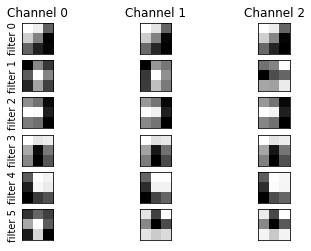

In [5]:
import matplotlib.pyplot as plt

# plot first fix filters
n_filters, ix = 6, 1
for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(3):
        # specify subplot and turn of axis
        ax = plt.subplot(n_filters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        if i == 0:
            ax.set_title("Channel %d" % (j))
        if ix % 3 == 1:
            ax.set_ylabel("filter %d" % (i))
        # plot filter channel in grayscale
        plt.imshow(f[:, :, j], cmap='gray')
        ix += 1
# show the figure
plt.show()

The above example creates a figure with six rows of three images, or 18 images, one row for each filter and one column for each channel (for rgb).

We can see that in some cases, the filter is the same across the channels (the first row), and in others, the filters differ (the last row).

The dark squares indicate small or inhibitory weights and the light squares represent large or excitatory weights. Using this intuition, we can see that the filters on the first row detect a gradient from light in the top left to dark in the bottom right.

#### Method 2: Visualize Feature Maps

The activation maps, called feature maps, capture the result of applying the filters to input, such as the input image or another feature map.

The idea of visualizing a feature map for a specific input image would be to understand what features of the input are detected or preserved in the feature maps. The expectation would be that the feature maps close to the input detect small or fine-grained detail, whereas feature maps close to the output of the model capture more general features.

In order to explore the visualization of feature maps, we need input for the VGG16 model that can be used to create activations. We will use this [bird](https://www.flickr.com/photos/husker_alum/8628754308/) image. You can download the image 'bird.jpg' on LMS the and place it in your current working directory.

Next, we need a clearer idea of the shape of the feature maps output by each of the convolutional layers and the layer index number so that we can retrieve the appropriate layer output.

The example below will enumerate all layers in the model and print the output size or feature map size for each convolutional layer as well as the layer index in the model.

In [6]:
# summarize feature map size for each conv layer
from keras.applications.vgg16 import VGG16

# load the model
model = VGG16()
# summarize feature map shapes
for i in range(len(model.layers)):
    layer = model.layers[i]
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue
    # summarize output shape
    print(i, layer.name, layer.output.shape)

1 block1_conv1 (?, 224, 224, 64)
2 block1_conv2 (?, 224, 224, 64)
4 block2_conv1 (?, 112, 112, 128)
5 block2_conv2 (?, 112, 112, 128)
7 block3_conv1 (?, 56, 56, 256)
8 block3_conv2 (?, 56, 56, 256)
9 block3_conv3 (?, 56, 56, 256)
11 block4_conv1 (?, 28, 28, 512)
12 block4_conv2 (?, 28, 28, 512)
13 block4_conv3 (?, 28, 28, 512)
15 block5_conv1 (?, 14, 14, 512)
16 block5_conv2 (?, 14, 14, 512)
17 block5_conv3 (?, 14, 14, 512)


We can use this information and design a new model that is a subset of the layers in the full VGG16 model. The model would have the same input layer as the original model, but the output would be the output of a given convolutional layer, which we know would be the activation of the layer or the feature map.

For example, after loading the VGG model, we can define a new model that outputs a feature map from the first convolutional layer (index 1) as follows.

In [7]:
from keras.models import Model

# redefine model to output right after the first hidden layer
model = Model(inputs=model.inputs, outputs=model.layers[1].output)

Making a prediction with this model will give the feature map for the first convolutional layer for a given provided input image. Let’s implement this.

After defining the model, we need to load the bird image with the size expected by the model, in this case, 224×224.

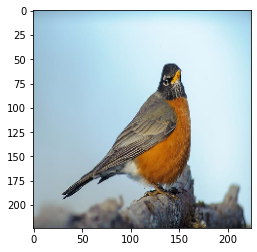

In [8]:
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img

# load the image with the required shape
img = load_img('bird.jpg', target_size=(224, 224))

#show the image after changing the shape
plt.imshow(img)
plt.show()

Next, the image PIL object needs to be converted to a NumPy array of pixel data and expanded from a 3D array to a 4D array with the dimensions of (samples, rows, cols, channels), where we only have one sample.

In [9]:
from keras.preprocessing.image import img_to_array
from numpy import expand_dims

# convert the image to an array with dimension of (rows, cols, channels)
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)

The pixel values then need to be scaled appropriately for the VGG model.

In [10]:
from keras.applications.vgg16 import preprocess_input

# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)

We are now ready to get the feature map. We can do this easy by calling the model.predict() function and passing in the prepared single image.

In [11]:
# get feature map for the first convolutional layer
feature_maps = model.predict(img)

We know the result will be a feature map with 224x224x64. We can plot all 64 two-dimensional images as an 8×8 square of images.

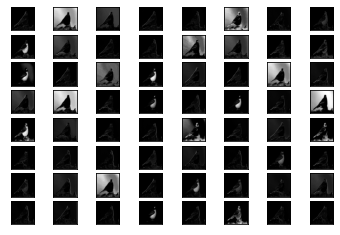

In [12]:
# plot all 64 maps in an 8x8 squares
square = 8
ix = 1
for _ in range(square):
    for _ in range(square):
        # specify subplot and turn of axis
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
        ix += 1
# show the figure
plt.show()

Instead of grey scale cmap (color map) to visualize, you can also try the default cmap 'viridis', as shown below.

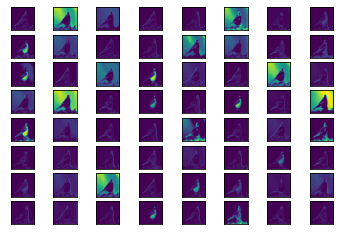

In [13]:
# plot all 64 maps in an 8x8 squares
square = 8
ix = 1
for _ in range(square):
    for _ in range(square):
        # specify subplot and turn of axis
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(feature_maps[0, :, :, ix-1])
        ix += 1
# show the figure
plt.show()

We can see that the result of applying the filters in the first convolutional layer is a lot of versions of the bird image with different features highlighted.

For example, some highlight lines, other focus on the background or the foreground.

This is an interesting result and generally matches our expectation. We could update the example to plot the feature maps from the output of other specific convolutional layers.

#### Visualize the effect of applying several convolutional layers

Another approach would be to collect feature maps output from each block of the model in a single pass, then create an image of each.

There are five main blocks in the image (e.g. block1, block2, etc.) that end in a pooling layer. The layer indexes of the last convolutional layer in each block are [2, 5, 9, 13, 17].

We can define a new model that has multiple outputs, one feature map output for each of the last convolutional layer in each block; for example:

In [14]:
from keras.applications.vgg16 import VGG16

# load the model
model = VGG16()
# summarize feature map shapes
for i in range(len(model.layers)):
    layer = model.layers[i]
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue
    # summarize output shape
    print(i, layer.name, layer.output.shape)
    
# redefine model to output right after the first hidden layer
ixs = [2, 5, 9, 13, 17]
outputs = [model.layers[i+1].output for i in ixs]
model = Model(inputs=model.inputs, outputs=outputs)
model.summary()

1 block1_conv1 (?, 224, 224, 64)
2 block1_conv2 (?, 224, 224, 64)
4 block2_conv1 (?, 112, 112, 128)
5 block2_conv2 (?, 112, 112, 128)
7 block3_conv1 (?, 56, 56, 256)
8 block3_conv2 (?, 56, 56, 256)
9 block3_conv3 (?, 56, 56, 256)
11 block4_conv1 (?, 28, 28, 512)
12 block4_conv2 (?, 28, 28, 512)
13 block4_conv3 (?, 28, 28, 512)
15 block5_conv1 (?, 14, 14, 512)
16 block5_conv2 (?, 14, 14, 512)
17 block5_conv3 (?, 14, 14, 512)
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D) 

Making a prediction with this new model will result in a list of feature maps.

We know that the number of feature maps (e.g. depth or number of channels) in deeper layers is much more than 64, such as 256 or 512. Nevertheless, we can cap the number of feature maps visualized at 64 for consistency.

In [15]:
# get feature maps for the selected layers
feature_maps = model.predict(img)

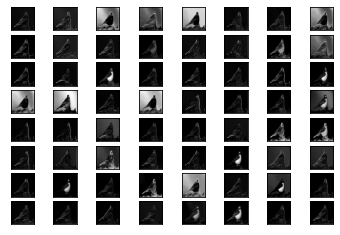

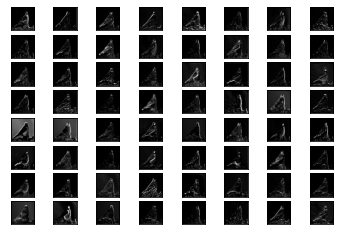

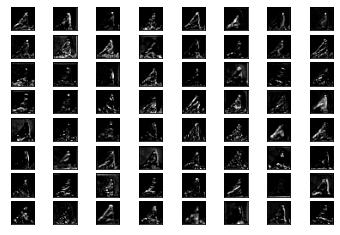

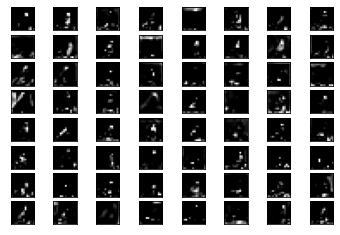

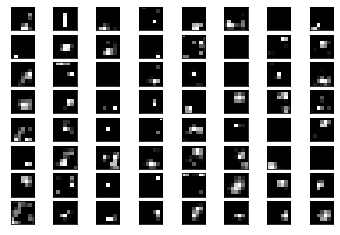

In [16]:
# plot the output from each block
square = 8
for fmap in feature_maps:
    # plot all 64 maps in an 8x8 squares
    ix = 1
    for _ in range(square):
        for _ in range(square):
            # specify subplot and turn of axis
            ax = plt.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            plt.imshow(fmap[0, :, :, ix-1], cmap='gray')
            ix += 1
    # show the figure
    plt.show()

We can see that the five feature maps from the the five main blocks of the VGG16 model closer to the input of the model capture a lot of fine detail in the image and that as we progress deeper into the model, the feature maps show less and less detail.

This pattern was to be expected, as the model abstracts the features from the image into more general concepts that can be used to make a classification. Although it is not clear from the final image that the model saw a bird, we generally lose the ability to interpret these deeper feature maps.